# ARIMA Models

---
This notebook will build two types of ARIMA models: ARIMA and SARIMA. These models will be used to forecast the price of Bitcoin. ARIMA stands for AutoRegressive, Integrated, Moving Average.

The metrics being used to compare the models are their AIC scores as Residual Sum of Squares (RSS). The AIC (Akaie Information Criterion) measures how well the model measures reality. This is explaining how well the model works on the training data (for those more familiar, this can be thought of as our training score). The RSS is the chosen error term as it harshly punishes incorrect forecasts, and does so in a more extreme way than other error metrics (such as MSE, MAE or RMSE). This is explaining how well the model works on the testing data (for those more familir, this can be thought of as our testing score).

To begin, a baseline ARIMA model was created as a reference point. The (p, d, q) inputs used in this ARIMA model were (1, 1, 1). For those not familiar with these values, the p refers to the autoregressive nature of the model. This was confirmed in the ACF charts in EDA and the expectation is that the proper value should be above 0, and is most likely significantly higher than 0. The d refers to differencing to achieve stationarity. In the EDA notebook, the data required one period differencing in order to achieve stationarity. The q refers to the moving average nature of the model. This was confirmed in the PACF charts in EDA and the expectation is that the proper value should be above 0.

Once this baseline model is established, then a function has been built in order to gridsearch over these three parameter values. The gridsearch will optimize either for AIC or RSS and based on the findings the two optimal models will be created and graphed to visualize their forecasts.

Then a baseline SARIMA model was created as a reference point. SARIMA is an extention of the ARIMA model, so the optimal ARIMA params will be used in the SARIMA model. The SARIMA model also has (p, d, q) inputs as well which will be determined by the ARIMA gridsearch, but then there is the seasonal inputs that will need to be tuned. Like the ARIMA model, the SARIMA model has a (p, d, q, s) order where the s is the seasonal component and the p, d, and q are the autoregressive, differencing, and moving average components of seasonality. Due to computing inefficiency, the SARIMA gridsearch was halted after 70 hours of continuous computing. While unfortunate that the 'best' SARIMA model was not found, based on the baseline model created and what was seen in the ARIMA model, the SARIMA model may have only been a slight improvement on the ARIMA model.

Note regarding the data: the data was converted to log values as the EDA showed the trend is exponential and differencing was more effective when done to the logged data.

Notebook note: The cells that run the various gridsearches have been commented out in this notebook as some of them (SARIMA GridSearch) take at least 6 hours to complete (one SARIMA GridSearch had to be stopped after 70 hours). The outputs of the completed GridSearches are also in those cells as comments but should someone choose to run the GridSearches themselves those lines of code will need to be uncommented. Each of the optimized models were built out and can be run.

## Table of Contents

- **[Import Libraries & DataFrame](#1)**
- **[Baseline ARIMA Model](#2)**
- **[ARIMA Model GridSearch](#3)**
- **[Baseline SARIMA Model](#4)**
- **[SARIMA Model GridSearch](#5)**

<a id="1"></a>
## Import Libraries and Data

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
import math

from sklearn import metrics
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [99]:
# import daily data
daily = pd.read_csv('./data/daily_clean.csv')

# change dat col to datetime
daily['date'] = pd.to_datetime(daily['date'])

# set date as index
daily.set_index('date', inplace=True)

# sort by index
daily.sort_index(inplace=True)

# confirm df
daily.head()

,high,low,open,close,volume
date,,,,,
2013-04-29 23:59:00,147.488007,134.000000,134.444000,144.539993,0.0
2013-04-30 23:59:00,146.929993,134.050003,144.000000,139.000000,0.0
2013-05-01 23:59:00,139.889999,107.720001,139.000000,116.989998,0.0
2013-05-02 23:59:00,125.599998,92.281898,116.379997,105.209999,0.0
2013-05-03 23:59:00,108.127998,79.099998,106.250000,97.750000,0.0


In [100]:
# set training and testing ranges
train = daily['close'][:-90]
test = daily['close'][-90:]

In [101]:
# create the log of the original data
daily_bc_log = pd.DataFrame(np.log(daily.close))

# Differencing the log values
log_diff = daily_bc_log.diff(1).dropna()

# set training and testing ranges
train_log = daily_bc_log[:-90]
test_log = daily_bc_log[-90:]
train_log_diff = log_diff[:-90]
test_log_diff = log_diff[-90:]

<a id="2"></a>
## Baseline ARIMA Model

---
This section builds a baseline ARIMA model with parameters of (1, 1, 1) using the logged data. 

In [102]:
# insatiate and fit arima aic model
arima_baseline = ARIMA(endog=train_log, order=(1, 1,1)).fit()

# print aic score
print(f'Baseline ARIMA AIC Score: {arima_baseline.aic}')

# generate forecasts for this model
arima_fcast_baseline = arima_baseline.predict(start=test_log.index[0], end=test_log.index[-1])

# exponentiate forecast
arima_fcast_baseline_real = math.e ** arima_fcast_baseline

# print RSS
print(f'Baseline ARIMA RSS Score: {metrics.mean_squared_error(test, arima_fcast_baseline_real) * len(test)}')

Baseline ARIMA AIC Score: -9773.781451510375
Baseline ARIMA RSS Score: 195663052732.51428


The baseline ARIMA model returned some not so steller numbers. The negative AIC score while extremely low, is too deep in negative territory to believe that this model is successfully explaining measuring reality. Then an RSS of 195,663,052,732.51428 is also insanely high. This would suggest that the ARIMA model is nowhere near properly forecasting the future price of Bitcoin and may not be worth gridsearching over. Below shows the Bitcoin time plot with the forecasted values included. There is no mistake 

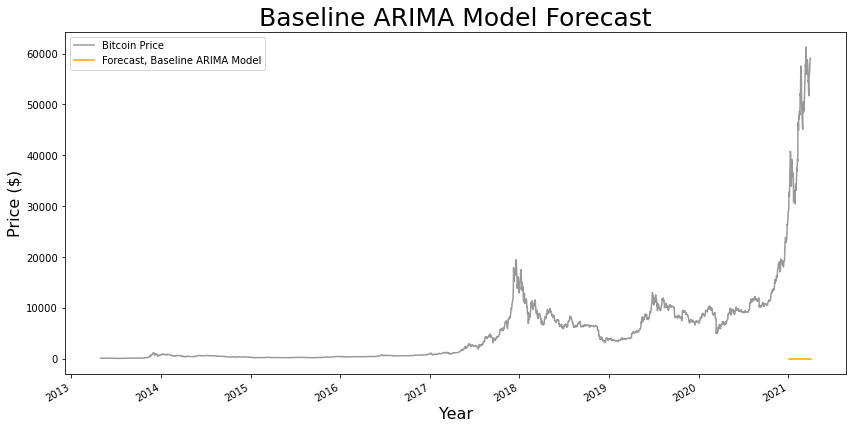

In [103]:
# plot true values
daily['close'].plot(alpha = 0.8, color='grey', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot forecasted values
arima_fcast_baseline_real.plot(color='orange', label='Forecast, Baseline ARIMA Model', legend=True)

# add title/x/y labels
plt.title('Baseline ARIMA Model Forecast', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

In case it was not seen, the forecasted values can be found at the bottom right of the graph. This was checked multiple times for error, but no error was found. These are the forecasted values for the price of Bitcoin in an ARIMA model. This is extremely surprising and dissapointing, however the gridsearch in the next section may help shed a lot of light on this.

<a id="3"></a>
## ARIMA Model GridSearch

___
This section builds a function to gridsearch over an ARIMA model. The three hyperparameters of an ARIMA model are AutoRegressive, Integrated, Moving Average (these words are what ARIMA is short for). 

Autoregressive helps to explain long-term trends in the data by regressing newer values on older values. The data is confirmed to have a trend which is why this model is being explored.

Integrated is the stationarity component of the model. When running the Augmented Dickey-Fuller test a one-period difference returned stationary data, which is why this model is being explored.

Moving Average helps to explain the sudden shocks in data by taking previous error (residual) terms as inputs. This is extremely helpful for predicting future values based on recent forecasting errors. 

The first gridsearch focuses on optimizing for AIC. The second gridsearch focuses on optimizing for RSS. Then each of the optimal models was built and their forecasts were evaluated to determine which performed better.

In [104]:
# create an arima gridsearch function optimizing aic
def arima_gs(train_log, test_log, true_test, pdq_range, optimization='AIC'):
    
    # set initial aic & rss
    best_aic = 100000000000000000000
    best_rss = 100000000000000000000
    
    # set range for p, q - both are same
    p = q = range(0, pdq_range)
    # range for d is controlled as this is the differencing metric. will check for 0, 1, and 2 diff
    d = range(0,3)
    
    # set list of orders
    pdq = list(itertools.product(p, d, q))
    
    # create a condition if optimizing for AIC - this will be default if no optimization is entered
    if optimization == 'AIC':
    
        # loop through each value in list
        for param in pdq:

            # run ARIMA model
            try:
                # insatiate and fit the model
                model = ARIMA(endog = train_log, order = param).fit()

                # generate predictions
                pred = model.predict(start=test_log.index[0], end=test_log.index[-1])

                # change preds to true val
                true_pred = math.e ** pred

                # get rmse
                error = metrics.mean_squared_error(true_test, true_pred) * len(true_test)

                # condition if new rmse is lower
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_rss = error
                    order = param

                # print statement after each order is checked
                print(f'ARIMA {param}: AIC {model.aic} / RSS {error}')

            except:
                continue

        print(f'The set of parameters with the minimum AIC {best_aic} is: ARIMA {order} with a RSS of {best_rss}.')
        
    # create condition if optimizing for RSS
    elif optimization == 'RSS':
        
        # loop through each value in list
        for param in pdq:

            # run ARIMA model
            try:
                # insatiate and fit the model
                model = ARIMA(endog = train_log, order = param).fit()

                # generate predictions
                pred = model.predict(start=test_log.index[0], end=test_log.index[-1])

                # change preds to true val
                true_pred = math.e ** pred

                # get rmse
                error = metrics.mean_squared_error(true_test, true_pred) * len(true_test)

                # condition if new rmse is lower
                if error < best_rss:
                    best_aic = model.aic
                    best_rss = error
                    order = param

                # print statement after each order is checked
                print(f'ARIMA {param}: AIC {model.aic} / RSS {error}')

            except:
                continue

        print(f'The set of parameters with the minimum RSS {best_rss} is: ARIMA {order} with an AIC of {best_aic}.')
        
    # print statement incase either AIC or RSS is not entered
    else:
        print('Optimization Metric Not Valid, please select either AIC or RSS')

In [105]:
### GRIDSEARCH CELL

# arima_gs(train_log, test_log, test, 8)

# OUTPUT: 
# The set of parameters with the minimum AIC -9803.978875555455 is: ARIMA (6, 1, 5) with a RSS of 195663055382.6728.

In [106]:
### GRIDSEARCH CELL

# arima_gs(train_log, test_log, test, 8, 'RSS')

# OUTPUT: 
# The set of parameters with the minimum RSS 18940753598.031494 is: ARIMA (2, 0, 1) with an AIC of -9763.586525933988.

The two different ARIMA model GridSearch's provided the following outputs:

    Optimizing for AIC: `The set of parameters with the minimum AIC -9803.978875555455 is: ARIMA (6, 1, 5) with a RSS of 195,663,055,382.6728`
    
    Optimizing for RSS: `The set of parameters with the minimum RSS 18,940,753,598.031494 is: ARIMA (2, 0, 1) with an AIC of -9763.586525933988`
    
One surprising finding from this is the ARIMA model optimized for RSS did not difference the data. This conflicts with the findings in EDA regarding stationarity and differencing: the data needed to be differenced once in order to achieve stationarity. The ARIMA model that optimized for AIC did use differencing, but the RSS was over ten times higher than the RSS optimized model. This would suggest that when the model optimizes for AIC, stationarity helps achieve this. 

As both AIC and RSS are being used to evaluate all models, both models will be built and visualized to determine if either model (if any) is properly forecasting the price of Bitcoin. 

In [107]:
# insatiate and fit arima aic model
arima_aic = ARIMA(endog=train_log, order=(6, 1,5)).fit()

# generate forecasts for this model
arima_fcast_aic = arima_aic.predict(start=test_log.index[0], end=test_log.index[-1])

# exponentiate forecast
arima_fcast_aic_real = math.e ** arima_fcast_aic

In [108]:
# insatiate and fit arima rss model
arima_rss = ARIMA(endog=train_log, order=(2, 0, 1)).fit()

# generate forecasts
arima_fcast_rss = arima_rss.predict(start=test_log.index[0], end=test_log.index[-1])

# exponentiate forecasts
arima_fcast_rss_real = math.e ** arima_fcast_rss

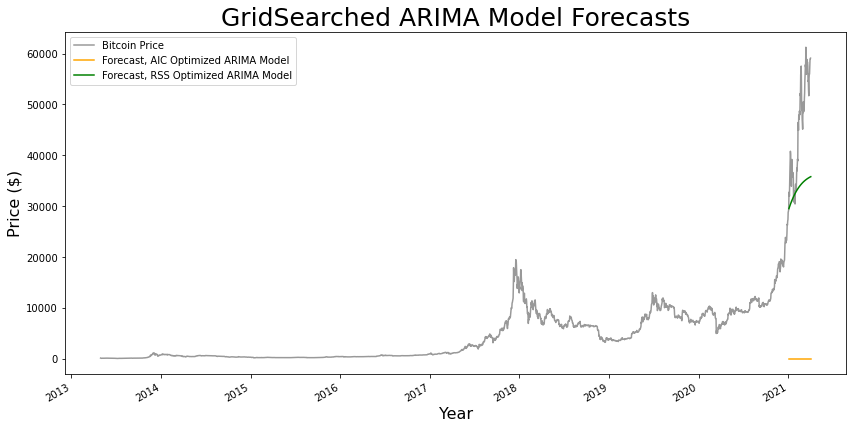

In [109]:
# plot true values
daily['close'].plot(alpha = 0.8, color='grey', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot forecasted values
arima_fcast_aic_real.plot(color='orange', label='Forecast, AIC Optimized ARIMA Model', legend=True)
arima_fcast_rss_real.plot(color='green', label='Forecast, RSS Optimized ARIMA Model', legend=True)

# set title/x/y labels
plt.title('GridSearched ARIMA Model Forecasts', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

The findings from the above graph were very disappointing but confirmed the previous findings. The AIC optimized ARIMA model included differencing and that forecast is very similar to the baseline ARIMA model forecast: all values are near 0. The RSS optimized ARIMA model did not include differencing and that forecast was a significant improvement compared to the AIC optimized model. While the RSS optimized ARIMA model forecast is an improvement on the other ARIMA model forecasts, it is still not great at forecasting long term. 

The next step would be to explore a SARIMA model with the optimial ARIMA parameters. The optimal ARIMA parameters are the ones used in the RSS optimized model: (2, 0, 1).

It is worth noting that these optimal parameters were also checked with differencing (2, 1, 1) to see if that was an improvement on the two previous differenced models (baseline ARIMA and AIC optimzed ARIMA). That is no longer shown but when visualized it overlapped the AIC optimzed forecast and was discarded as a result.

<a id="4"></a>
## Baseline SARIMA Model

___
This section builds out a baseline SARIMA model. The parameters being used for the trend order are (2, 0, 1) as these were the best parameters determined in the ARIMA model gridsearch. Then the seasonal order will use the same first three inputs and then a value of 30 for the seasonal component (2, 0, 1, 30). This is a little bit of a guess as the seasonality is there, but the seasonalities 

In [110]:
#runing Sarima model with p, d, q as 2, 0, 1, respectively as a baseline SARIMA model
# using the same values for seasonal order although this could prove faulty
# using 30 as the seasonal period as that was the smallest value of seasonality
sarima = sm.tsa.statespace.SARIMAX(endog = train_log,
                                   order = (2, 0, 1),
                                   seasonal_order = (2,0,1, 30)).fit()

In [111]:
# generate forecast for this model
sarima_fcast_baseline = sarima.predict(start=test_log.index[0], end=test_log.index[-1])

# exponentiate forecast
sarima_fcast_real = math.e ** sarima_fcast_baseline

# print aic
print(f'Baseline SARIMA AIC Score: {sarima.aic}')

# calculate RMSE 
print(f'Baseline SARIMA RSS Score: {metrics.mean_squared_error(test, sarima_fcast_real)* len(test)}')

Baseline SARIMA AIC Score: -9740.440828143015
Baseline SARIMA RSS Score: 29845744454.063686


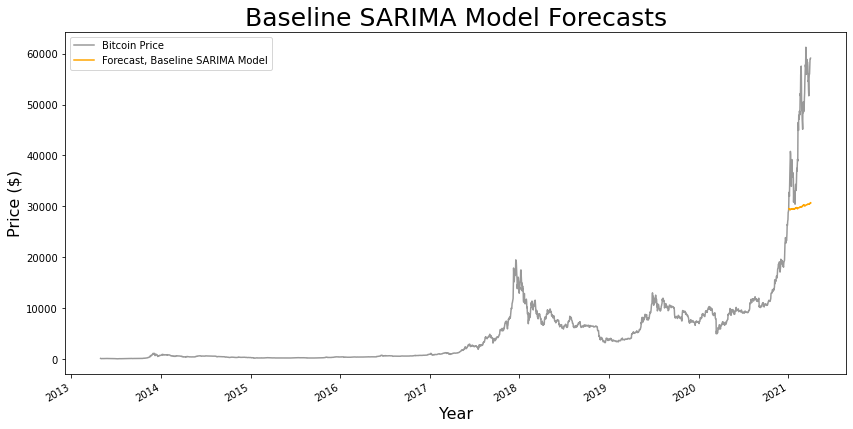

In [112]:
# plot true values
daily['close'].plot(alpha = 0.8, color='grey', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot forecasted values
sarima_fcast_real.plot(color='orange', label='Forecast, Baseline SARIMA Model', legend=True)

# set title/x/y labels
plt.title('Baseline SARIMA Model Forecasts', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

The baseline SARIMA model shows a significant improvement on the RSS score when compared to the best ARIMA model. The baseline SARIMA RSS score was 29,845,744,454.063686. While it is not surprising that the RSS score was poor, it was surprising that the baseline SARIMA model's RSS was very close to the RSS optimized ARIMA model.

Based on these outputs, the SARIMA model is am improvement to the ARIMA model and is worth having its parameters gridsearched over.

<a id="5"></a>
## SARIMA Model Gridsearch

___
This section builds out a function to gridsearch over the hyperparameters of the SARIMA model. Two models were built: one that optimizes for AIC and one that optimizes for RSS. To avoid overdoing the gridsearch, different blocks were created to search over smaller batches of parameters. 

Unfortunately there was not enough computing power to complete all the gridsearches and after 70 hours of consecutive searching the gridsearch was ended. As a result no decisive conclusion could be drawn regarding the SARIMA model and one recommendation would be to complete this gridsearch in order to find the best SARIMA model parameters. 

In [113]:
# build function to do a manual gridsearch over SARIMA params optimizing for aic
def sarima_gs_aic(train, test, true_test, pdq_range_lower, pdq_range_upper, seasonal_period):
    
    # set initial aic & rmse
    best_aic = 1000000000000000000
    best_rss = 1000000000000000000
    
    # set range for p,d,q
    p = q = range(pdq_range_lower, pdq_range_upper)
    d = range(0,2)
    
    # set list of possible orders
    pdq = list(itertools.product(p, d, q))
    
    # set list of possible seasonal orders
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
    # loop through each value in the order
    for param in pdq:
        
        # loop through each value in the seasonal pdq
        for param_seasonal in seasonal_pdq:
            
            # run a SARIMA model for each order/seasonal pdq
            try:
                # insatiate & fit model
                sarima = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit()
                
                # generate predictions
                fcast = sarima.predict(start=test.index[0], end = test.index[-1])
                
                # exponentiate preds 
                true_fcast = math.e ** fcast
                
                # get rmse
                error = metrics.mean_squared_error(true_test, true_fcast) * len(test)

                # new condition only if rmse is lower
                if sarima.aic < best_aic:
                    best_rss = error
                    best_aic = sarima.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                # print statement after each order is checked
                print(f'SARIMA{param}x{param_seasonal} - AIC:{sarima.aic}')
                
            except:
                continue
    
    print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{best_aic} - RSS{best_rss}')

In [114]:
# build function to do a manual gridsearch over SARIMA params optimizing for rss
def sarima_gs_rss(train, test, true_test, pdq_range_lower, pdq_range_upper, seasonal_period):
    
    # set initial aic & rmse
    best_aic = 1000000000000000000
    best_rss = 1000000000000000000
    
    # set range for p,d,q
    p = q = range(pdq_range_lower, pdq_range_upper)
    d = range(0,2)
    
    # set list of possible orders
    pdq = list(itertools.product(p, d, q))
    
    # set list of possible seasonal orders
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
    # loop through each value in the order
    for param in pdq:
        
        # loop through each value in the seasonal pdq
        for param_seasonal in seasonal_pdq:
            
            # run a SARIMA model for each order/seasonal pdq
            try:
                
                # insatiate & fit model
                sarima = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit()
                
                # generate predictions
                fcast = sarima.predict(start=test.index[0], end = test.index[-1])
                
                # exponentiate preds 
                true_fcast = math.e ** fcast
                
                # get rmse
                error = metrics.mean_squared_error(true_test, true_fcast) * len(test)

                # new condition only if rss is lower
                if error < best_rss:
                    best_rss = error
                    best_aic = sarima.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                # print statement after each order is checked
                print(f'SARIMA{param}x{param_seasonal} - AIC:{sarima.aic}')
                
            except:
                print('hi')
                
    print(f'The set of parameters with the minimum RSS is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{best_aic} - RSS{best_rss}')

In [115]:
### GRIDSEARCH CELL

# sarima_gs_aic(train_log, test_log, test, 0, 3, 30)

# OUTPUT: 
# The set of parameters with the minimum AIC is: SARIMA(1, 1, 2)x(0, 0, 1, 30) - AIC:-9775.04078021729 - RSS24573606014.329235

In [116]:
### GRIDSEARCH CELL

# sarima_gs_aic(train_log, test_log, test, 3, 6, 30)

# OUTPUT:
# NONE - tried running this code - it ran for about 70 hours and only finished half the gridsearch before I stopped it

In [117]:
### GRIDSEARCH CELL 

# sarima_gs_rss(train_log, test_log, test, 0, 3, 30)

# OUTPUT: 
# The set of parameters with the minimum RSS is: SARIMA(2, 0, 0)x(2, 1, 0, 30) - AIC:-8821.249991627563 - RSS7395120381.605706

In [118]:
# GRIDSEACH CELL

# sarima_gs_rss(train_log, test_log, test, 3, 6, 30)

# OUTPUT: 
# this code was not run due to time constraints but could be run

The two different SARIMA model GridSearch's provided the following outputs:

    Optimizing for AIC: `The set of parameters with the minimum AIC is: SARIMA(1, 1, 2)x(0, 0, 1, 30) - AIC: -9,775.04078021729 - RSS 24,573,606,014.329235`
    
    Optimizing for RSS: `The set of parameters with the minimum RSS is: SARIMA(2, 0, 0)x(2, 1, 0, 30) - AIC: -8,821.249991627563 - RSS 7,395,120,381.605706`

While these gridsearches were not able to check values above 2 for any inputs, the limited gridsearch did provide some interesting findings. The SARIMA model optimized for RSS was significantly better than the ARIMA model optimized for RSS. This further validates the seasonality component of the data. 

To better visualize these differenced, each of these models has been built below.

In [119]:
# build out the aic optimized SARIMA model
sarima_aic = sm.tsa.statespace.SARIMAX(endog = train_log,
                                   order = (1, 1, 2),
                                   seasonal_order = (0,0,1, 30)).fit()

# generate forecast for this model
sarima_fcast_aic = sarima_aic.predict(start=test_log.index[0], end=test_log.index[-1])

# exponentiate forecast
sarima_fcast_aic_real = math.e ** sarima_fcast_aic

In [120]:
# build out the aic optimized SARIMA model
sarima_rss = sm.tsa.statespace.SARIMAX(endog = train_log,
                                   order = (2, 0, 0),
                                   seasonal_order = (2,1,0, 30)).fit()

# generate forecast for this model
sarima_fcast_rss = sarima_rss.predict(start=test_log.index[0], end=test_log.index[-1])

# exponentiate forecast
sarima_fcast_rss_real = math.e ** sarima_fcast_rss

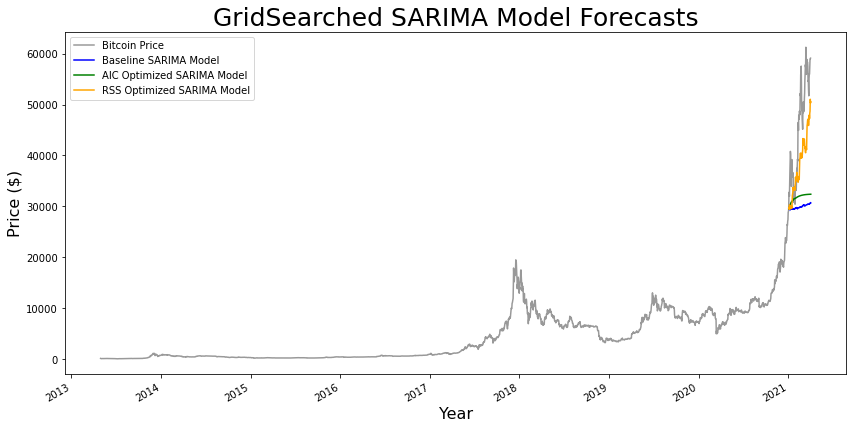

In [121]:
# plot true values
daily['close'].plot(alpha = 0.8, color='grey', label='Bitcoin Price', legend=True, figsize=(14, 7))

# plot forecasted values
sarima_fcast_real.plot(color='blue', label='Baseline SARIMA Model', legend=True)
sarima_fcast_aic_real.plot(color='green', label='AIC Optimized SARIMA Model', legend=True)
sarima_fcast_rss_real.plot(color='orange', label='RSS Optimized SARIMA Model', legend=True)

# set title/x/y labels
plt.title('GridSearched SARIMA Model Forecasts', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price ($)', fontsize=16);

From the above visualization, both the AIC and RSS optimized gridsearches came back with better forecasts than the baseline SARIMA model. 

The AIC optimized SARIMA model forecasted a higher price, but began to level off far below the actual price of Bitcoin.

The RSS optimized SARIMA model was the first model that did not only forecast the price of Bitcoin going up. The price is steadily increasing, however there are pullbacks that are similar to the real price of Bitcoin. This suggests that the SARIMA model is the best at forecasting the price of Bitcoin so far.


| Model | Optimized | AIC | RSS |
|--|--|--|--|
| ARIMA | AIC | -9,803.978875555455 | 195,663,055,382.6728 |
| ARIMA | RSS | -9,763.586525933988 | 18,940,753,598.031494 |
| SARIMA | AIC | -9,775.04078021729 | 24,573,606,014.329235 |
| SARIMA | RSS | -8,821.249991627563 | 7,395,120,381.605706 |